In [1]:
# Load necessary packages
library(tidyverse)
library(xgboost)
library(lubridate)

── Attaching packages ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.6     ✔ dplyr   1.0.7
✔ tidyr   1.1.4     ✔ stringr 1.4.0
✔ readr   2.0.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘xgboost’


The following object is masked from ‘package:dplyr’:

    slice



Attaching package: ‘lubridate’


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union




In [54]:
train <- read.csv('train_GBT.csv')
test <- read.csv('val_GBT.csv')

In [44]:
train <- train[1600000:1807143,]

In [68]:
table(train$label)


      0       1 
1760006   47137 

In [39]:
table(train$label)


      0       1 
1760006   47137 

In [55]:
test <- dplyr::select(test, -c(label))

In [4]:
test <- dplyr::select(test, -c(label))

In [57]:
colnames(train) <- c('bay_mean', 'vh_mean', 'vh_max', 'vv_max', 'vh_min', 'vv_min', 'land', 'NaN', 'label')

In [58]:
colnames(test) <- c('bay_mean', 'vh_mean', 'vh_max', 'vv_max', 'vh_min', 'vv_min', 'land', 'NaN', 'label')

In [4]:
table(ship$label)


      0       1 
1760006   47137 

In [60]:
head(test)

,bay_mean,vh_mean,vh_max,vv_max,vh_min,vv_min,land,NaN,label
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,-23.646917,-29.42854,-10.757812,-0.7231445,-37.75000,-28.89062,0,0,1
2,-3.097254,-27.96644,-17.265625,-9.9843750,-35.96875,-35.81250,1,0,1
3,-63.608036,-22.67235,7.812500,13.6953125,-35.06250,-23.54688,0,0,1
4,-24.389372,-29.88335,-13.570312,-8.9531250,-39.87500,-33.78125,0,0,1
5,-24.004875,-27.78874,-17.328125,-11.9296875,-36.21875,-27.10938,0,0,1
6,-10.095329,-27.84885,-1.973633,9.7343750,-40.56250,-21.23438,0,0,1


In [17]:
# Load in data, make sure to set working directly to source file location
test <- read.csv('val_GBT.csv')

In [60]:
table(test$label)


     0      1 
177367   5922 

In [11]:
table(train$class)


    0     1     2     3 
11354  3261  5305  2817 

In [61]:
#Put Train into Matrix form
features <- dplyr::select(train, -c(label))
labels <- dplyr::select(train, label)
features_train <- data.matrix(features)
response_train <- data.matrix(labels)

In [62]:
#Put Validation into Matrix form
features <- dplyr::select(test, -c(label))
labels <- dplyr::select(test, label)
features_test <- data.matrix(features)
response_test <- data.matrix(labels)

In [11]:
# Prepare first round grid search parameters
parameter_grid_boost <- expand.grid(
  max.depth.options = c(5),#how deep each tree grows, deeper to tree the more overfitting, should be close to 5
  eta.options = c(.005, .01, .3),#learning rate, need to try bunch of values
  subsample.options = c(.3,1),#make subsample lower to reduce overfitting, should be around .5
  min_child_weight.options = c(4),
  early_stopping.options = c(25,75),
  optimal_ntrees = 0#gets overwritten, just default setting, check out -https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/
)

In [12]:
nrow(parameter_grid_boost)

[1] 12

In [13]:
# Function to perform grid search, if you want it to be quiet set verbose to 0
do_grid_search <- function(param_grid, nrounds){
  
  grid <- param_grid
  
  for(i in 1:nrow(grid)){
    print(i)
    
    xgbcv.fit <- xgb.cv(
      data = features_train,
      label = response_train,
      nrounds = nrounds,
      nfold = 5,
      objective = "binary:logistic",
      eta = grid$eta.options[i],
      max.depth = grid$max.depth.options[i],
      subsample = grid$subsample.options[i],
      min_child_weight = grid$min_child_weight.options[i],
      early_stopping_rounds = grid$early_stopping.options[i],
      verbose = 0,
      na.action='na.pass'
    )
    
    grid$min_mlogloss_mean[i] <- min(xgbcv.fit$evaluation_log$test_logloss_mean)
    grid$optimal_ntrees[i] <- which.min(xgbcv.fit$evaluation_log$test_logloss_mean)
  }
  
  return(grid)
}

In [14]:
# Do grid search on initial parameter grid
first_grid <- do_grid_search(parameter_grid_boost, 2000)

# Examining results
first_grid %>%
  dplyr::arrange(min_mlogloss_mean) %>%
  head(10)

[1] 1
[04:32:19] WARNING: amalgamation/../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[04:32:20] WARNING: amalgamation/../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[04:32:21] WARNING: amalgamation/../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[04:32:22] WARNING: amalgamation/../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Expl

,max.depth.options,eta.options,subsample.options,min_child_weight.options,early_stopping.options,optimal_ntrees,min_mlogloss_mean
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,5,0.010,0.3,4,25,2000,0.0072216
2,5,0.300,1.0,4,75,144,0.0072356
3,5,0.010,0.3,4,75,1999,0.0072396
4,5,0.300,1.0,4,25,142,0.0072540
5,5,0.010,1.0,4,25,1999,0.0073526
6,5,0.010,1.0,4,75,1999,0.0073686
7,5,0.300,0.3,4,25,89,0.0075336
8,5,0.300,0.3,4,75,70,0.0075518
9,5,0.005,0.3,4,25,2000,0.0077122


In [17]:
# Second Grid Search
parameter_grid_boost_2 <- expand.grid(
  max.depth.options = c(3),
  eta.options = c(.01,.3),
  subsample.options = c(.3),
  min_child_weight.options = c(4),
  early_stopping.options = c(25),
  optimal_ntrees = 0
)

In [18]:
nrow(parameter_grid_boost_2)

[1] 2

In [19]:
# Do grid search on second parameter grid
second_grid <- do_grid_search(parameter_grid_boost_2, 3500)

# Examining results
second_grid %>%
  dplyr::arrange(min_mlogloss_mean) %>%
  head(20)

[1] 1
[19:03:31] WARNING: amalgamation/../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:03:31] WARNING: amalgamation/../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:03:32] WARNING: amalgamation/../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:03:33] WARNING: amalgamation/../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Expl

,max.depth.options,eta.options,subsample.options,min_child_weight.options,early_stopping.options,optimal_ntrees,min_mlogloss_mean
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,3,0.01,0.3,4,25,3500,0.0074294
2,3,0.30,0.3,4,25,251,0.0074586


In [ ]:
# A final grid comparing just four models
parameter_grid_boost_3 <- expand.grid(
  max.depth.options = c(3),
  eta.options = c(.01,.3),
  subsample.options = c(.5),
  min_child_weight.options = c(5,6),
  early_stopping.options = c(40),
  min_RMSE = 0,
  optimal_ntrees = 0
)

In [ ]:
last_grid <- do_grid_search(parameter_grid_boost_3, 6000)

# Examining results
last_grid %>%
  dplyr::arrange(min_mlogloss_mean) %>%
  head(10)

In [20]:
# Drill down on nrounds for most successful model
xgbcv.fit <- xgb.cv(
  data = features_train,
  label = response_train,
  nrounds = 2000,
  nfold = 5,
  subsample = .3,
  objective = "binary:logistic",
  eta = .01,
  max.depth = 3,
  min_child_weight = 4,
  early_stopping_rounds = 25,
  verbose = 0,
  na.action='na.pass'
)

[20:47:40] WARNING: amalgamation/../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:47:41] WARNING: amalgamation/../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:47:42] WARNING: amalgamation/../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:47:43] WARNING: amalgamation/../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly

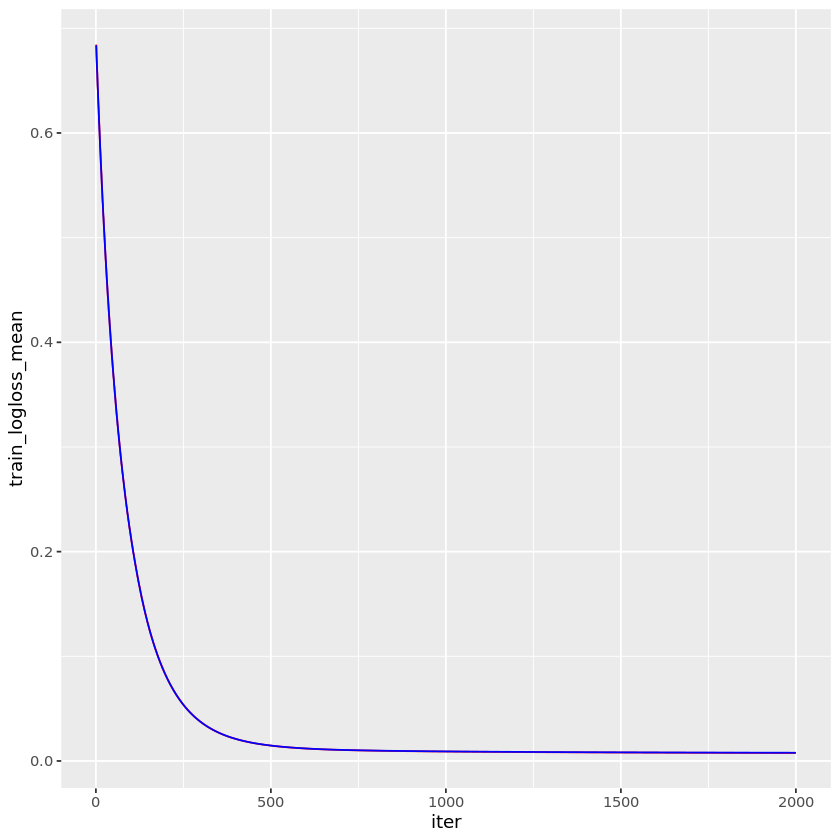

In [21]:
#Plot training root mean sqaured error versus testing root mean square error
ggplot(xgbcv.fit$evaluation_log) +
  geom_line(aes(iter, train_logloss_mean), color = "red") +
  geom_line(aes(iter, test_logloss_mean), color = "blue")

In [23]:
optimal_rounds <- which.min(xgbcv.fit$evaluation_log$test_logloss_mean)
print(optimal_rounds)

[1] 2000


In [63]:
# Train final model
xgb.fit.final <- xgboost(
  data = features_train,
  label = response_train,
  nrounds = 2000,
  objective = "binary:logistic",
  eta = .01,
  subsample = .3,
  max.depth = 3,
  min_child_weight = 4,
  early_stopping_rounds = 25,
  verbose = 0,
  missing = NA
)

[23:35:42] WARNING: amalgamation/../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


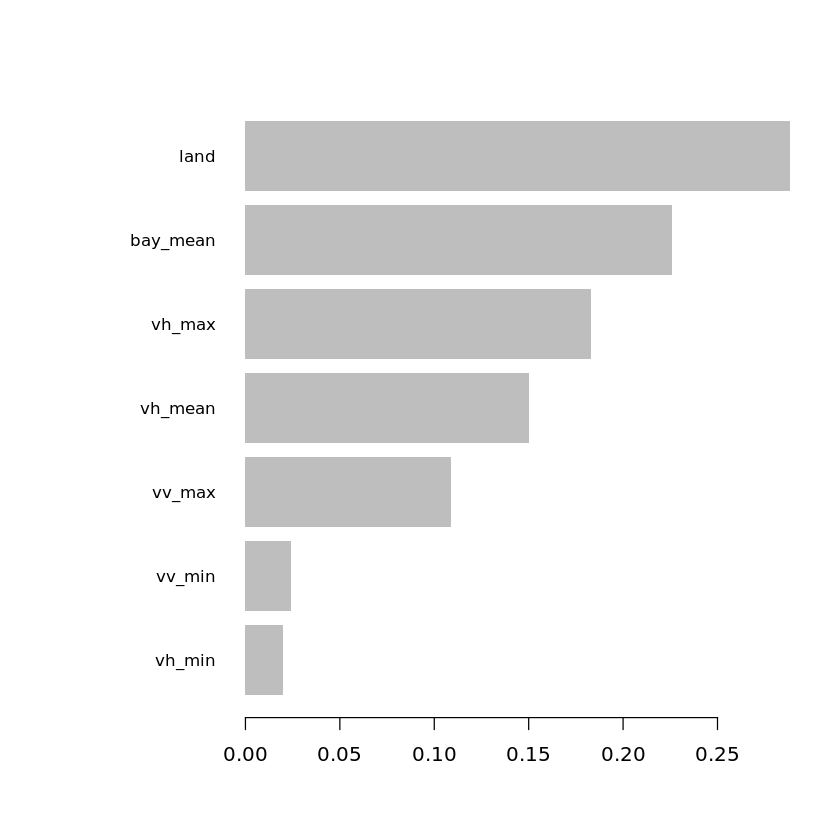

In [64]:
# create importance matrix
importance_matrix <- xgb.importance(model = xgb.fit.final)

# variable importance plot
xgb.plot.importance(importance_matrix, top_n = 10, measure = "Gain")

In [65]:
#Generate Predictions
boost_pred <- predict(xgb.fit.final, features_test)

In [50]:
cor(boost_pred,response_test)^2

label
0.8819418


In [15]:
head(boost_pred)

[1] 0.9159982 0.1172425 0.9752628 0.9171527 0.8193316 0.9906666

In [28]:
length(boost_pred) == length(response_test)

[1] TRUE

In [66]:
pred = matrix(nrow = length(boost_pred))
for (i in 1:length(boost_pred)){
    if (boost_pred[i] >= 0.5){
        pred[i,1] <- 1
    }
    else{
        pred[i,1] <- 0    
    }
}


In [30]:
pred[1]

[1] 1

In [67]:
#Evaluation Metrics
TP = 0
FP = 0
FN = 0
TN = 0
# TP_V = 0
# FP_V = 0
# FN_V = 0

# TP_F = 0
# FP_F = 0
# FN_F = 0

for (i in 1:length(boost_pred)){
    if (pred[i] == 1 && response_test[i] == 1){
        TP = TP + 1
    }
    if (pred[i] == 0 && response_test[i] == 1){
        FN = FN + 1
    }
    if (pred[i] == 1 && response_test[i] == 0){
        FP = FP + 1
    }
    if (pred[i] == 0 && response_test[i] == 0){
        TN = TN + 1
    }
    
    
#     if (boost_pred[i] == 2 && response_test[i] == 2){
#         TP_V = TP_V + 1
#     }
#     if (boost_pred[i] == 2 && response_test[i] == 1){
#         FP_V = FP_V + 1
#     }
#     if (boost_pred[i] == 1 && response_test[i] == 2){
#         FN_V = FN_V + 1
#     }
    
    
#     if (boost_pred[i] == 3 && response_test[i] == 3){
#         TP_F = TP_F + 1
#     }
#     if (boost_pred[i] == 3 && (response_test[i] == 2 || response_test[i] == 1)){
#         FP_F = FP_F + 1
#     }
#     if (boost_pred[i] == 2 && response_test[i] == 3){
#         FN_F = FN_F + 1
#     }
}
print(TP)
print(FP)
print(FN)
print(TN)
F1_D = TP / (TP + 0.5*(FP + FN))
# F1_V = TP_V / (TP_V + 0.5*(FP_V + FN_V))
# F1_F = TP_F / (TP_F + 0.5*(FP_F + FN_F))
        
print(F1_D)
# print(F1_V)
# print(F1_F)

# M_R = F1_D * (1 + F1_V + F1_F) / 3
# print(M_R)

[1] 5274
[1] 250
[1] 648
[1] 177117
[1] 0.9215446


In [21]:
print(length(boost_pred))

[1] 183289


In [19]:
print(TP)

[1] 2825


In [20]:
print(FP)

[1] 2857


In [21]:
print(FN)

[1] 3


Warning message:
“Removed 3873 rows containing missing values (geom_point).”


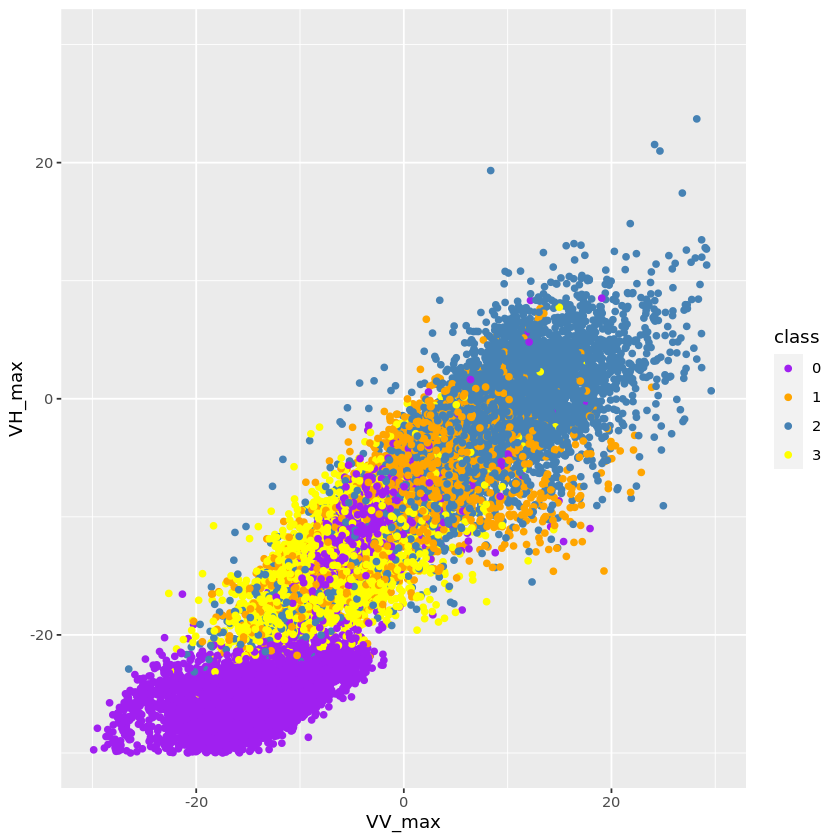

In [40]:
#Figures
plot <- transform(train, class = as.factor(class))
ggplot(plot, aes(VV_max, VH_max, colour = class)) + geom_point() + 
    scale_color_manual(values = c('0' = "purple", '1' = "orange", '2' = "steelblue", '3' = "yellow")) + xlim(-30,30) + ylim(-30,30)
